In [ ]:
import os
#os.environ['PYTHONHASHSEED'] = '0'

import tensorflow as tf
#tf.random.set_seed(89)

import numpy as np
#np.random.seed(42)

import random as rn
#rn.seed(1254)

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/ff_dataset.zip" -d /content/

## Parameters

In [ ]:
BATCH_SIZE = 64
SIZE = 224
EPOCHS = 50

input_shape = (SIZE, SIZE, 3)
learning_rate = 0.001
dl_rate = 1

## Store into tf.data.Dataset

### FaceForensics++

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dir_train = os.path.join('ff_dataset', 'Frames_train')
dir_val = os.path.join('ff_dataset', 'Frames_validation')
dir_test = os.path.join('ff_dataset', 'Frames_test')
image_format = '.jpg'

training_dataset = image_dataset_from_directory(
    dir_train,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=42
)

validation_dataset = image_dataset_from_directory(
    dir_val,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=42
)


Found 46402 files belonging to 2 classes.
Found 15407 files belonging to 2 classes.


### Deepfake_Database

In [ ]:
'''
from tensorflow.keras.preprocessing import image_dataset_from_directory

directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

training_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed=42
)

validation_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed=42
)
'''

'\nfrom tensorflow.keras.preprocessing import image_dataset_from_directory\n\ndirectory = os.path.join(\'deepfake_database\', \'train_test\')\nimage_format = \'.jpg\'\n\ntraining_dataset = image_dataset_from_directory(\n    directory,\n    labels="inferred",\n    label_mode="binary",\n    class_names=[\'df\', \'real\'],\n    color_mode="rgb",\n    batch_size=BATCH_SIZE,\n    image_size=(SIZE, SIZE),\n    shuffle=True,\n    validation_split=0.1,\n    subset="training",\n    seed=42\n)\n\nvalidation_dataset = image_dataset_from_directory(\n    directory,\n    labels="inferred",\n    label_mode="binary",\n    class_names=[\'df\', \'real\'],\n    color_mode="rgb",\n    batch_size=BATCH_SIZE,\n    image_size=(SIZE, SIZE),\n    shuffle=True,\n    validation_split=0.1,\n    subset="validation",\n    seed=42\n)\n'

In [ ]:
steps_per_epoch=len(training_dataset)
print(steps_per_epoch)

726


# Model

## LR Decay

In [ ]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch):
    lr = 1e-3
    if epoch < 10:
        lr = 0.005 
    if epoch >= 10 and epoch< 20:
        lr = 0.001 
    elif epoch >= 20 and epoch < 30:
        lr = 0.001
    elif epoch >= 30 and epoch < 40:
        lr = 0.0001
    elif epoch >= 40:
        lr = 0.0001
    print("{0:.8f}".format(lr))
    return lr

## Compile Model

In [ ]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU, Embedding, LSTM
from keras.optimizers import Adam

%run -i 'classifiers.py'

model, modelName = Meso4VGG16(input_shape)
optimizer = Adam(lr = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
print(modelName)

Meso4VGG16


# Training

## Fit Model

In [ ]:
from tensorflow import keras
import keras.backend as K

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(training_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[callback],
                    workers=4)
round(model.optimizer.lr.numpy(), 5)


Epoch 1/50
0.00500000
726/726 [==============================] - 139s 186ms/step - loss: 0.2964 - accuracy: 0.5657 - val_loss: 0.2232 - val_accuracy: 0.6875
Epoch 2/50
0.00500000
726/726 [==============================] - 136s 187ms/step - loss: 0.1827 - accuracy: 0.7364 - val_loss: 0.2067 - val_accuracy: 0.7055
Epoch 3/50
0.00500000
726/726 [==============================] - 137s 188ms/step - loss: 0.1328 - accuracy: 0.8193 - val_loss: 0.1633 - val_accuracy: 0.7817
Epoch 4/50
0.00500000
726/726 [==============================] - 137s 188ms/step - loss: 0.1038 - accuracy: 0.8632 - val_loss: 0.1646 - val_accuracy: 0.7684
Epoch 5/50
0.00500000
726/726 [==============================] - 137s 188ms/step - loss: 0.0849 - accuracy: 0.8886 - val_loss: 0.1879 - val_accuracy: 0.7685
Epoch 6/50
0.00500000
726/726 [==============================] - 136s 187ms/step - loss: 0.0689 - accuracy: 0.9123 - val_loss: 0.1881 - val_accuracy: 0.7765
Epoch 7/50
0.00500000
726/726 [===========================

1e-04

## Training and Validation Graphs

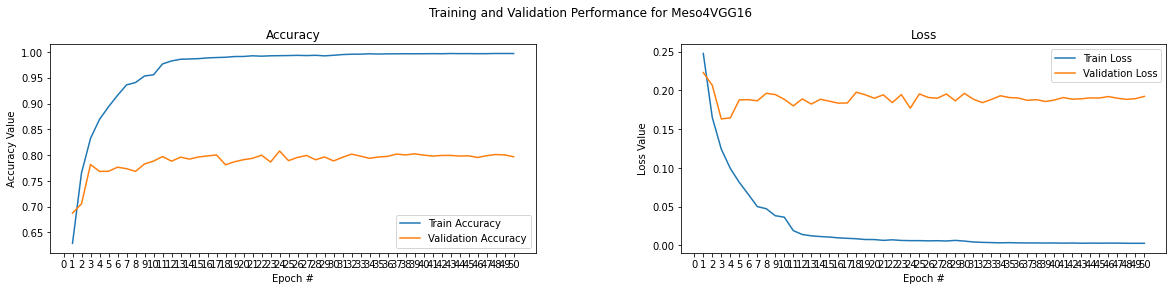

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Prediction

In [ ]:
model = keras.models.load_model('model.h5')

## Store into tf.data.Dataset

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dir_train = os.path.join('ff_dataset', 'Frames_train')
dir_val = os.path.join('ff_dataset', 'Frames_validation')
dir_test = os.path.join('ff_dataset', 'Frames_test')
image_format = '.jpg'

test_dataset = image_dataset_from_directory(
    dir_test,
    labels="inferred",
    label_mode="binary",
    class_names=['fake', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=False,
)


Found 15667 files belonging to 2 classes.


In [ ]:
'''
from tensorflow.keras.preprocessing import image_dataset_from_directory

directory = os.path.join('deepfake_database', 'validation')
image_format = '.jpg'

test_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=False,
)
'''

'\nfrom tensorflow.keras.preprocessing import image_dataset_from_directory\n\ndirectory = os.path.join(\'deepfake_database\', \'validation\')\nimage_format = \'.jpg\'\n\ntest_dataset = image_dataset_from_directory(\n    directory,\n    labels="inferred",\n    label_mode="binary",\n    class_names=[\'df\', \'real\'],\n    color_mode="rgb",\n    batch_size=BATCH_SIZE,\n    image_size=(SIZE, SIZE),\n    shuffle=False,\n)\n'

## Make Prediction

In [ ]:
Y_pred = (model.predict(test_dataset, verbose=1) > 0.5).astype("int32")

245/245 [==============================] - 23s 95ms/step


### Read Original Labels

In [ ]:
Y_test = []
for img_array, label in (test_dataset.as_numpy_iterator()):
    Y_test.append(label)

### Flatten Original and Prediction label arrays

In [ ]:
original_labels = []
original_labels = list(np.concatenate(Y_test).flat)
original_labels = np.array(original_labels)

predicted_labels = []
predicted_labels = list(np.concatenate(Y_pred).flat)
predicted_labels = np.array(predicted_labels)

## Classification Report

In [ ]:
from sklearn.metrics import classification_report
classificationReport = classification_report(original_labels, predicted_labels, target_names=test_dataset.class_names, digits=4)
print(classificationReport)

              precision    recall  f1-score   support

        fake     0.8728    0.8020    0.8359      7983
        real     0.8102    0.8786    0.8430      7684

    accuracy                         0.8395     15667
   macro avg     0.8415    0.8403    0.8395     15667
weighted avg     0.8421    0.8395    0.8394     15667



## Confusion Matrix

True positive =  6168
False positive =  1815
False negative =  907
True negative =  6777




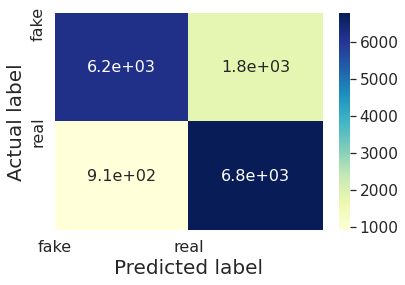

In [ ]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.yticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.ylim([2, 0])
    plt.show()
    return cm
    
confusionMatrix = print_confusion_matrix(original_labels, predicted_labels)

# Write to File

In [ ]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + str(modelName) + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Epochs: ' + str(EPOCHS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' ' + modelName + '.txt')

myFile = open(filename, 'w')
myFile.write(data)
myFile.close()

model.save(modelName + ' ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5')

In [ ]:
'''
from tensorflow import keras

loaded_model = keras.models.load_model('Meso4VGG16 2021-01-16 0134.h5')
loaded_model.summary()
'''

"\nfrom tensorflow import keras\n\nloaded_model = keras.models.load_model('Meso4VGG16 2021-01-16 0134.h5')\nloaded_model.summary()\n"